In [1]:
import pandas as pd
import sklearn
import numpy as np
import util
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import seaborn as sns

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import pydotplus
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from dtreeviz.trees import dtreeviz
import lightgbm as lgb

In [3]:
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm 
import matplotlib.pylab as plt 
from dmba import regressionSummary, exhaustive_search 
from dmba import adjusted_r2_score, AIC_score, BIC_score
from sklearn.metrics import r2_score
from dmba import backward_elimination, forward_selection

In [4]:
pd.set_option('max_columns', None)
pd.set_option('max_rows', 81)

In [25]:
ultimate_df = pd.read_csv('Data/Created Datasets/ALL_merge_truncate3.csv', index_col = 0)
#feature = pd.read_csv('Data/Created Datasets/KSI_Feature_Collapse.csv', index_col = 0)
#count = pd.read_csv('Data/Created Datasets/KSI_Collapse_Count_truncate3.csv')

In [54]:
# dataset without hazardous dataset - this dataset is bigger

ultimate_df = pd.read_csv('Data/Created Datasets/Impediments_Feature_Count.csv', index_col = 0)

In [55]:
# only downtown

ultimate_df = ultimate_df[(ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700)]

In [36]:
# not downtown

ultimate_df = ultimate_df[~((ultimate_df['LATITUDE'] < 43.6688) & (ultimate_df['LONGITUDE'] > -79.46935) & (ultimate_df['LONGITUDE'] < -79.330700))]

<AxesSubplot:ylabel='Frequency'>

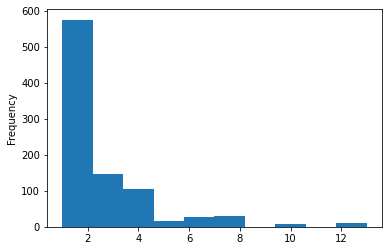

In [8]:
ultimate_df['COUNT'].plot(kind = 'hist')

In [56]:
ultimate_df['LIGHT'] = ultimate_df['LIGHT'].apply(util.lc)
ultimate_df['TRAFFCTL'] = ultimate_df['TRAFFCTL'].apply(util.tc)
ultimate_df['DRIVACT'] = ultimate_df['DRIVACT'].apply(util.actc)
ultimate_df['DRIVCOND'] = ultimate_df['DRIVCOND'].apply(util.condc)
ultimate_df['VEHTYPE'] = ultimate_df['VEHTYPE'].apply(util.vehc)
ultimate_df['INVAGE'] = ultimate_df['INVAGE'].apply(util.agec)
#ultimate_df['MANOEUVER'] = ultimate_df['MANOEUVER'].apply(util.manc)

In [33]:
ultimate_df.isna().sum()

IncidentsTotal       0
SeverityScore        0
PercentOfVehicles    0
AvgAcceleration      0
LATITUDE             0
LONGITUDE            0
COUNT                0
INVAGE               0
RDSFCOND             0
VISIBILITY           0
LIGHT                0
TRAFFCTL             0
DRIVACT              0
DRIVCOND             0
VEHTYPE              0
TIME                 0
dtype: int64

In [7]:
# TREATING ACTUAL NULLS INTRODUCED BECAUSE OF THE RIGHT MERGE OF HAZARDOUS WITH ROAD IMPEDIMENTS
# THOSE VALUES WILL BECOME 0s SINCE THERE WERE NO HARSH BREAKING INCIDENTS AT THOSE PLACES

ultimate_df.fillna(ultimate_df.mean(), inplace = True)

In [8]:
ultimate_df.isna().sum()

IncidentsTotal       0
SeverityScore        0
PercentOfVehicles    0
AvgAcceleration      0
LATITUDE             0
LONGITUDE            0
COUNT                0
INVAGE               0
RDSFCOND             0
VISIBILITY           0
LIGHT                0
TRAFFCTL             0
DRIVACT              0
DRIVCOND             0
VEHTYPE              0
TIME                 0
dtype: int64

In [28]:
print(ultimate_df['DRIVCOND'].unique())
print(ultimate_df['DRIVACT'].unique())
print(ultimate_df['LIGHT'].unique())
print(ultimate_df['TRAFFCTL'].unique())
print(ultimate_df['VEHTYPE'].unique())
print(ultimate_df['INVAGE'].unique())
#print(ultimate_df['MANOEUVER'].unique())

['Normal' 'Inattentive' '<Null>' 'Ability Impaired (Drugs/Alcohol)'
 'Unknown' 'Medical or Physical Disability' 'Other' 'Fatigue']
['Improper Turn' 'Failed to Yield Right of Way' '<Null>' 'Lost control'
 'Improper Passing' 'Disobeyed Traffic Control' 'Improper Lane Change'
 'Speed too Fast For Condition' 'Speeding' 'Following too Close' 'Other'
 'Wrong Way on One Way Road']
['Daylight' 'Artificial' 'Dark' 'Dusk' 'Dawn']
['Traffic Signal' 'No Control' 'Stop/Yield Sign' 'Streetcar (Stop for)'
 'Controller present' 'Pedestrian Crossover']
['Small-size Vehicle' 'Two Wheeler' 'Large-size Vehicle'
 'Medium-size Vehicle' 'Other']
['Adult' 'Senior' 'Super Senior' 'Young Adult' 'Children']


In [57]:
ultimate_df = ultimate_df.replace('Yes', 1).replace('<Null>', 0).replace('<Null', 0)

In [58]:
ultimate_df['TIME'] = round(ultimate_df['TIME']/100,3)
#ultimate_df.head()

In [48]:
X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude',  'PercentCar', 'PercentHDT', 'PercentLDT', 'PercentMDT', 'PercentMPV', 'PercentOther')]]

X = pd.get_dummies(X, drop_first = True)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]

In [27]:
X.shape

(921, 51)

In [63]:
# ONLY RUN THESE FOR LIGHTGBM

X = ultimate_df[[col for col in ultimate_df.columns if col not in ('COUNT', 'WARDNUM', 'LATITUDE', 'LONGITUDE', 'Latitude', 'Longitude', 'IncidentsTotal', 'TIME')]]


#X = pd.get_dummies(X)

# need to remove the columns with 0s in their names
# the columns with 0 in their names are the ones which are structural zeros/not applicables

#X = X[[col for col in X.columns if '0' not in col]]

# ABSOLUTELY IMPORTANT STEP

for c in X.columns:
    col_type = X[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        X[c] = X[c].astype('category')
        X[c] = X[c].cat.codes


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [59]:
Y = ultimate_df['COUNT']

train_X, valid_X, train_Y, valid_Y =  train_test_split(X, Y, test_size = 0.2, random_state = 1)

ValueError: Found input variables with inconsistent numbers of samples: [3030, 921]

In [42]:
# Does the model perform better than the null model?
# Our created models must be able to beat this:
# I'm comparing valid_Y to the mean of COUNT. 

regressionSummary(valid_Y, np.repeat(Y.mean(), valid_Y.shape))


Regression statistics

                      Mean Error (ME) : -0.0300
       Root Mean Squared Error (RMSE) : 1.4807
            Mean Absolute Error (MAE) : 1.1277
          Mean Percentage Error (MPE) : -44.3746
Mean Absolute Percentage Error (MAPE) : 68.6258


In [60]:
param_grid = { 
 'max_depth': [3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
 'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001], 
 'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005] 
} 

In [61]:
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state = 1), param_grid, cv = 5, n_jobs = -1)
gridSearch.fit(train_X, train_Y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [3, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12],
                         'min_impurity_decrease': [0.05, 0.02, 0.01, 0.001],
                         'min_samples_split': [0.1, 0.07, 0.05, 0.01, 0.005]})

In [62]:
gridSearch.best_estimator_

DecisionTreeRegressor(max_depth=12, min_impurity_decrease=0.01,
                      min_samples_split=0.07, random_state=1)

In [19]:
# this creates a unique looking dctree with distributions of variables and the split shown

viz = dtreeviz(gridSearch.best_estimator_, valid_X, valid_Y,
               target_name="COUNT",
               feature_names= valid_X.columns,
               title="test")

viz.save("decision_tree_wine.svg")

X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.
Mean of empty slice.
invalid value encountered in double_scalars


In [380]:
# this creates a LARGE dctree visual - DON'T RUN otherwise

import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(gridSearch.best_estimator_, 
                           feature_names=valid_X.columns, 
                           filled=True, impurity=True, 
                           rounded=True)

graph = graphviz.Source(dot_data, format='png')
#graph

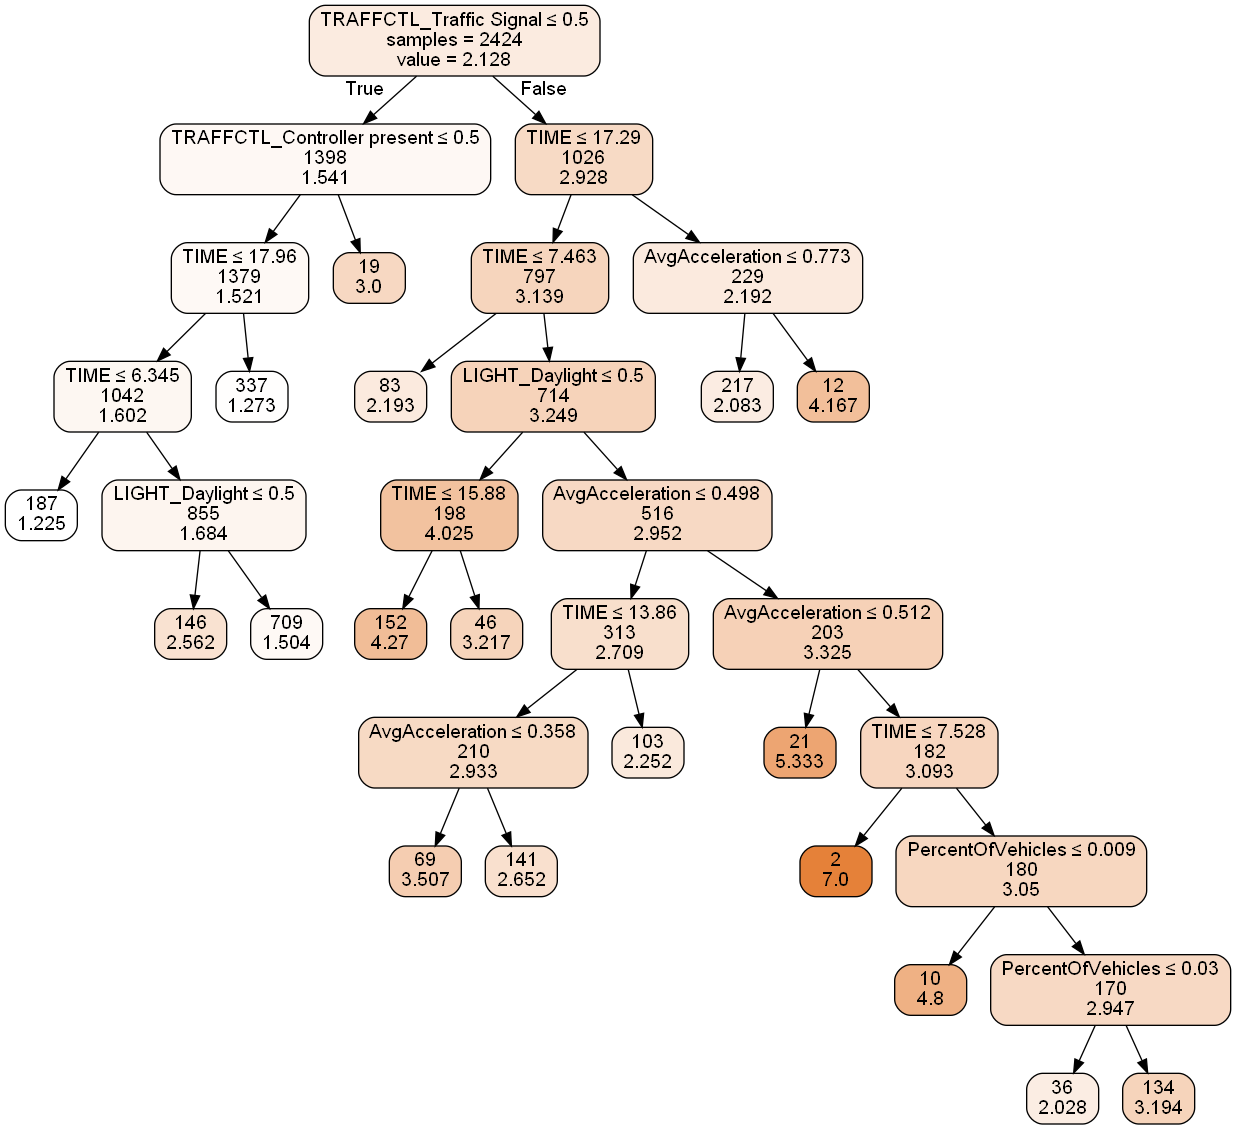

In [63]:
plotDecisionTree(gridSearch.best_estimator_, train_X.columns)

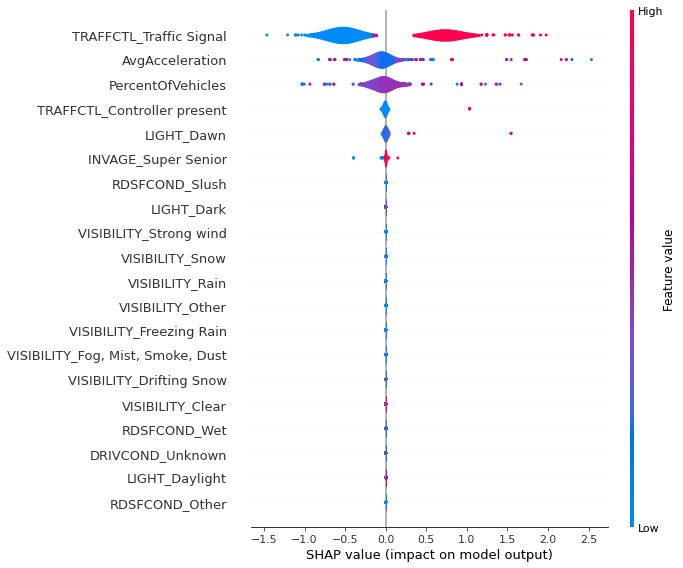

In [47]:
explainer = shap.TreeExplainer(gridSearch.best_estimator_)
shap_values = explainer.shap_values(valid_X)
shap.summary_plot(shap_values, valid_X, plot_type = 'violin')

In [34]:
print(regressionSummary(train_Y, gridSearch.best_estimator_.predict(train_X)))
regressionSummary(valid_Y, gridSearch.best_estimator_.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1.6792
            Mean Absolute Error (MAE) : 1.1948
          Mean Percentage Error (MPE) : -38.6752
Mean Absolute Percentage Error (MAPE) : 63.5725
None

Regression statistics

                      Mean Error (ME) : -0.0463
       Root Mean Squared Error (RMSE) : 1.7460
            Mean Absolute Error (MAE) : 1.2485
          Mean Percentage Error (MPE) : -45.7583
Mean Absolute Percentage Error (MAPE) : 71.5687


In [43]:
fit_params={"early_stopping_rounds": 50, 
            "eval_metric" : 'l2', 
            "eval_set" : [(valid_X, valid_Y), (train_X, train_Y)],
            'eval_names': ['valid','train'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto' # automatically deals with cat features
           }
           
lgbreg = lgb.LGBMRegressor(num_leaves= 15, max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='l2', 
                         n_jobs= -1, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)

lgbreg.fit(train_X, train_Y, **fit_params)

'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


[100]	train's l2: 0.335094	valid's l2: 1.32436
[200]	train's l2: 0.119615	valid's l2: 1.13225
[300]	train's l2: 0.0535624	valid's l2: 1.06881
[400]	train's l2: 0.0272885	valid's l2: 1.04371
[500]	train's l2: 0.0147823	valid's l2: 1.02338
[600]	train's l2: 0.00868586	valid's l2: 1.01641
[700]	train's l2: 0.00527084	valid's l2: 1.01158
[800]	train's l2: 0.00326951	valid's l2: 1.00761
[900]	train's l2: 0.00210175	valid's l2: 1.00349
[1000]	train's l2: 0.00137648	valid's l2: 1.00153


LGBMRegressor(colsample_bytree=0.9, metric='l2', n_estimators=1000,
              num_leaves=15, random_state=314, silent=True, subsample=0.9)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

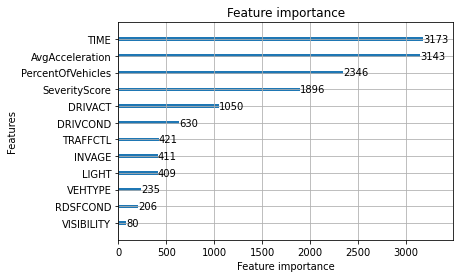

In [44]:
lgb.plot_importance(lgbreg)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l2'>

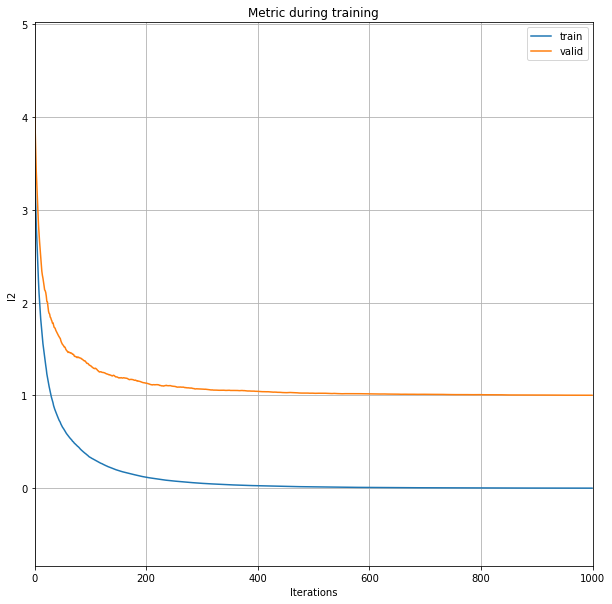

In [45]:
lgb.plot_metric(lgbreg, figsize = (10,10))

<AxesSubplot:>

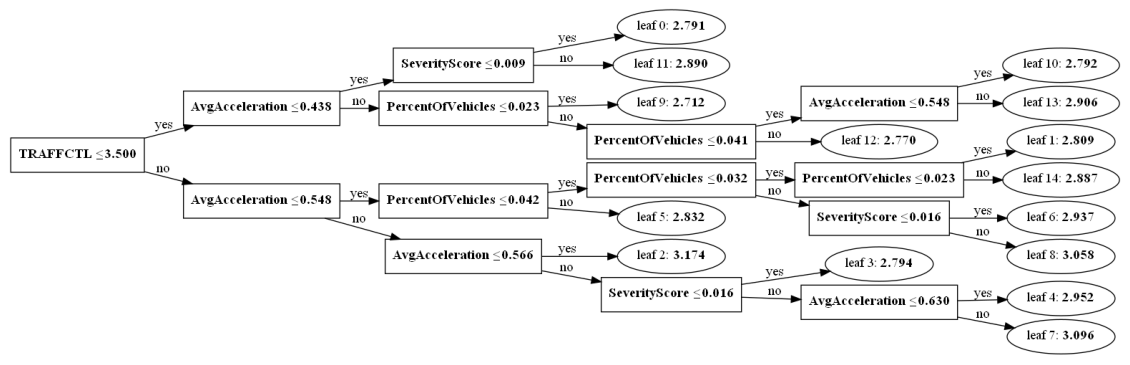

In [46]:
lgb.plot_tree(lgbreg ,figsize=(20,20))

In [123]:
print(regressionSummary(train_Y, lgbreg.predict(train_X)))
regressionSummary(valid_Y, lgbreg.predict(valid_X))

NameError: name 'lgbreg' is not defined

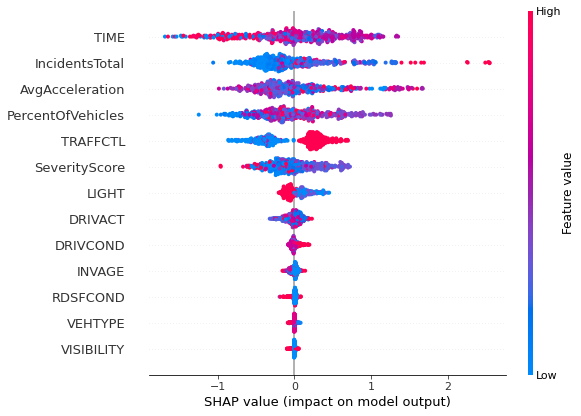

In [475]:
explainer = shap.Explainer(lgbreg)
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, train_X)

In [53]:
rf = RandomForestRegressor(n_estimators = 2000, random_state = 1) 
rf.fit(train_X, train_Y)

RandomForestRegressor(n_estimators=2000, random_state=1)

Text(0.5, 1.0, 'Visualizing Important Features')

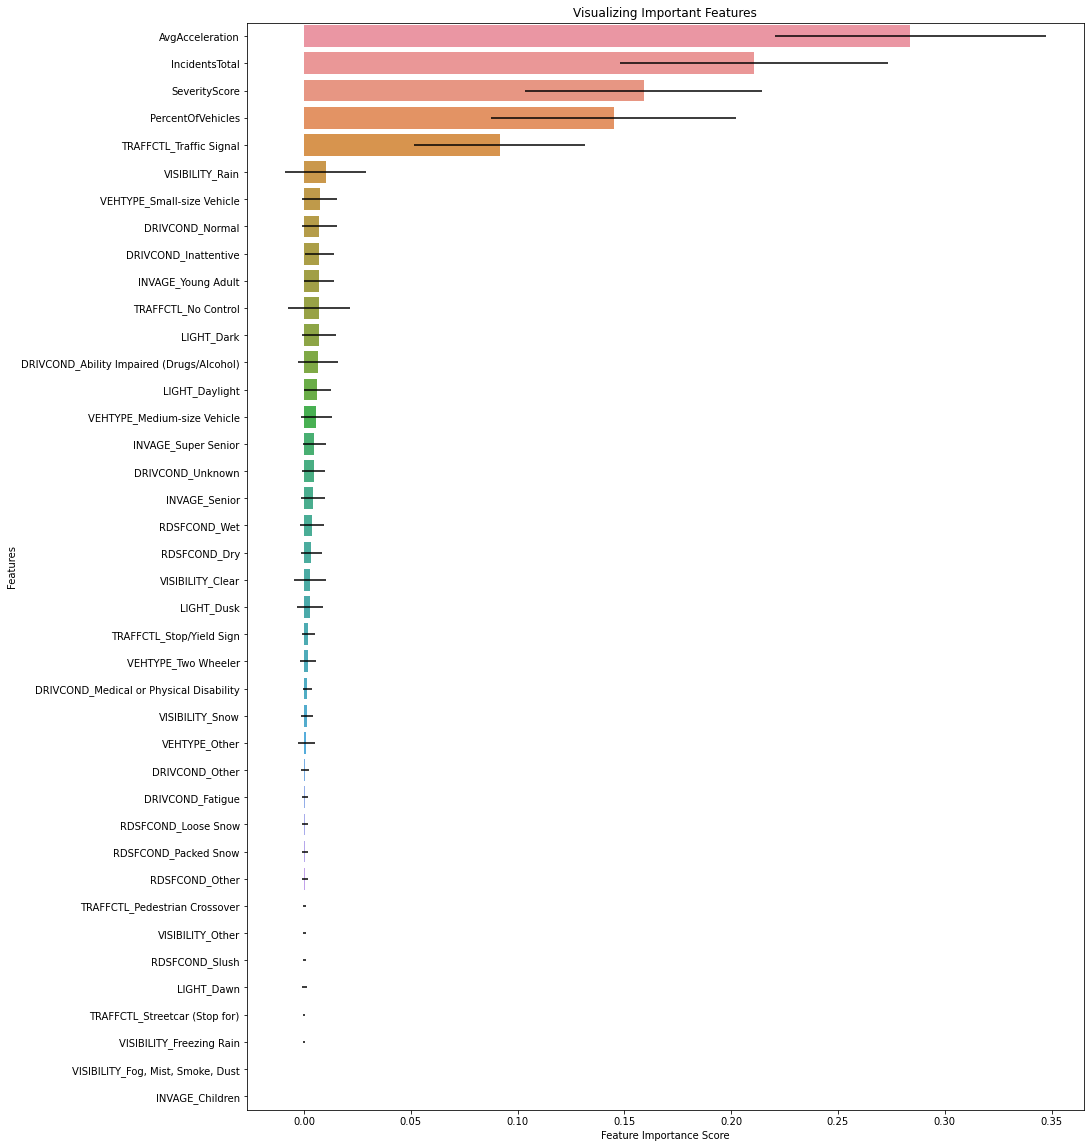

In [54]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0) 
tf = pd.DataFrame({'feature': train_X.columns, 'importance': rf.feature_importances_, 'std': std}) 
tf = tf.sort_values('importance', ascending = False)
plt.figure(figsize = (15,20))
sns.barplot(x = tf['importance'], y = tf['feature'], xerr = tf['std'])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")

In [55]:
print(regressionSummary(train_Y, rf.predict(train_X)))
regressionSummary(valid_Y, rf.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0521
       Root Mean Squared Error (RMSE) : 0.4523
            Mean Absolute Error (MAE) : 0.3327
          Mean Percentage Error (MPE) : -14.1790
Mean Absolute Percentage Error (MAPE) : 20.5997
None

Regression statistics

                      Mean Error (ME) : -0.1403
       Root Mean Squared Error (RMSE) : 1.1834
            Mean Absolute Error (MAE) : 0.8649
          Mean Percentage Error (MPE) : -38.4360
Mean Absolute Percentage Error (MAPE) : 54.5422


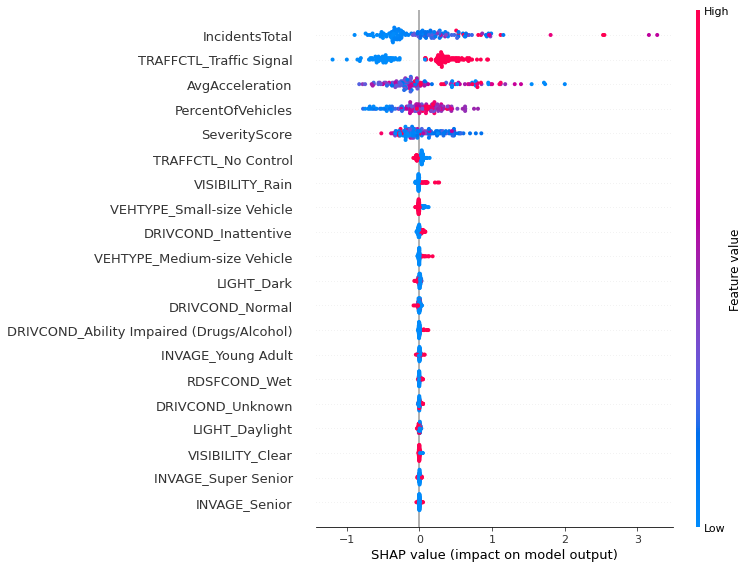

In [56]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(valid_X)
shap.summary_plot(shap_values, valid_X)